In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDatasetEmbedding, UnpairedEmbeddingsDataset
from generators import  OneHotGenerator, SkipOneHotGenerator, SkipTensorEmbeddingGen, TensorEmbeddingGen
from discriminators import MultiChannelDiscriminator 
import os
import glob
import generators

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
# config
PHASES = [1, 3]
UNPAIRED = True 
SKIPCONNECTIONS = True
EMBEDDING = True
if EMBEDDING == True:
    DOWN = False
    BOTTLENECK = True
ONEHOTENCODING = True


# LR scheduler
MultiStepLR = False
GAMMA = 0.1

ReduceLROnPlateau = False
FACTOR = 0.001
PATIENCE = 2

PolinomialLR = True
power = 1
LR_DECAY_AFTER_EPOCH = 50



DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
LEARNING_RATE = 0.0002 #1e-2 
NUM_WORKERS = 16
NUM_EPOCHS = 100

SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"  # RVtot_kalibriert existiert auch
source_signals = [SIG_D]
CHANNELS = len(source_signals)
WINDOW = 256

GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample

# Use adversarial loss
GAN_LOSS = True   # adversarial loss
LAMBDA_GAN = 1.0
# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 10.0
# Use supervised loss
SUPERVISED = False 
LAMBDA_SUPERVISED = 1.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 10.0

### Load all data and preprocess

Subsamplen, normalisieren pro Datei

In [3]:
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files" 
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
df = pd.DataFrame()
scaler = StandardScaler() 
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df_temp = pd.read_csv(f, sep=";")
    df_temp = utils.drop_cols(df_temp)
    df_temp = df_temp.dropna()
    df_temp = utils.remove_strings(df_temp)
    df_temp = utils.subsample(df_temp, 10)
    df_temp = utils.normalize(df_temp, scaler, phase1 = True)  
      
    # print the content
    df = pd.concat([df, df_temp], axis=0)
    

print(df.shape)

(6022044, 14)


In [4]:
# get unique 'contractility'
# contractility = df['contractility'].unique()
# print(contractility) # [1.0 4.0 3.0]

In [5]:
# visualize the data
# utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'Phasenzuordnung', 'animal'], 500)

### Select part of data to use in experiment

In [6]:
# select which phases to use
df = df.loc[df['Phasenzuordnung'].isin(PHASES)]
print('Size of the dataset after selecting Phasenzuordnung 1',df.shape)

print('Size of the dataset with data from phase 1',df.shape)
print('Size of Phase 1: ', df.loc[df['Phasenzuordnung'] == 1].shape)
print('Size of Phase 2: ', df.loc[df['Phasenzuordnung'] == 2].shape)
print('Size of Phase 3: ', df.loc[df['Phasenzuordnung'] == 3].shape)
print('Size of Phase 4: ', df.loc[df['Phasenzuordnung'] == 4].shape)
print('SIze of Phase 5: ', df.loc[df['Phasenzuordnung'] == 5].shape)

Size of the dataset after selecting Phasenzuordnung 1 (2122212, 14)
Size of the dataset with data from phase 1 (2122212, 14)
Size of Phase 1:  (751120, 14)
Size of Phase 2:  (0, 14)
Size of Phase 3:  (1371092, 14)
Size of Phase 4:  (0, 14)
SIze of Phase 5:  (0, 14)


In [7]:
df = df.reset_index(drop=True)

for index, row in df.iterrows():
    if row['Phasenzuordnung'] == 1:
        # change the intervention to 11
        df.at[index, 'intervention'] = 0
    # elif row['Phasenzuordnung'] != 1 and row['intervention'] == 10:
    #     df.at[index, 'intervention'] = 5

#get unique intervention
print(df['intervention'].unique())
print(df['Phasenzuordnung'].unique())

[ 0.  1.  3. 10.  2.  4.]
[1 3]


### Drop animals with less than 10 data points
We drop animals from the dataframe, if they have less than 10 data points. Initially, we have 56 animals and after dropping those with close to no data points, we are left with 25 animals

In [8]:
print(len(df['animal'].unique()))
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('Number of animals after removing those with less than 10 data points: ', len(df['animal'].unique()))

# get all differnent animals
animals = df['animal'].unique()
print(animals)

25
Number of animals after removing those with less than 10 data points:  25
[  8  12  13 108   7  14  11   2  16  10 105 111  17  19   3  15   5  20
 113   4 102   1   9 107 101]


### Split data into train and test split

The 5 test animals represent 20.20924% of the whole data. If we don't use all phases, this number might be different

In [9]:
# select animals 2,3, 7, 10 and 16 as test animals
test_animals = [3,4,8,11,17] # 3,4,8,11,17
print('\nTest animal(s):', test_animals)

all_animals = df['animal'].unique()
# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

# test data
df_test = df[df['animal'].isin(test_animals)]

# change the length of the test data to a multiple of the Window size
df_test = df_test.iloc[:len(df_test) - (len(df_test) % WINDOW)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: ',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Test animal(s): [3, 4, 8, 11, 17]

Different animal IDs after removing those that are in the test dataset:  20

Train data shape: (1506963, 14)

Test data shape: (615168, 14)

The test dataset is 28.98821986013116 percent of the whole data: 


#### Initialize Generator and Discriminator

We also initialize the 2 optimizers, the 2 Learning rate schedulers, the losses

In [40]:
# Generator
if ONEHOTENCODING and not SKIPCONNECTIONS:
    gen_target = OneHotGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    gen_source = OneHotGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

if ONEHOTENCODING and SKIPCONNECTIONS:
    gen_target = SkipOneHotGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    gen_source = SkipOneHotGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

if not ONEHOTENCODING and SKIPCONNECTIONS:
    gen_target = SkipTensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    gen_source = SkipTensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

if not ONEHOTENCODING and not SKIPCONNECTIONS:
    gen_target = TensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    gen_source = TensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

# Discriminator
disc_target = MultiChannelDiscriminator(CHANNELS = 1).to(DEVICE)
disc_source = MultiChannelDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# Optimizers 
opt_disc = torch.optim.AdamW(                                         
    list(disc_source.parameters()) + list(disc_target.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_source.parameters()) + list(gen_target.parameters()),
    lr=LEARNING_RATE,
)

# Scheduler
if ReduceLROnPlateau:
    gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_gen,
                                                           factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                           min_lr=1e-6,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_disc,
                                                            factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                            min_lr=1e-6,
                                                    )
if MultiStepLR:
    gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_gen, milestones=[5,6,7,8], gamma=GAMMA)
                                                        
    disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_disc, milestones=[5,6,7,8], gamma=GAMMA)

if PolinomialLR:
    gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = power,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = power,
                                                    )

# losses
l1 = nn.L1Loss() 
mse = nn.MSELoss() 

#### Create the dataset and DataLoader

In [41]:
if UNPAIRED and EMBEDDING:
    # create dataset with information of the phases and intervention (embedding information)
    train_dataset = UnpairedEmbeddingsDataset(df_train, source_signals, target_name = TARGET, window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, window_length = WINDOW)

if not UNPAIRED and EMBEDDING:
    train_dataset = AnimalDatasetEmbedding(df_train, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, test = True, window_length = WINDOW)


# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)

#### Initialize weights and bias

In [42]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Cycle_GAN",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "epochs": NUM_EPOCHS,
    }
)

Learning rate,▁▁▁▁
Test/Adversarial or GAN loss A,▁▅█
Test/Adversarial or GAN loss B,██▁
Test/Cycle consistency loss A,▁▁█
Test/Cycle consistency loss B,▁▄█
Test/Discriminator A loss,█▁▁
Test/Discriminator B loss,▁▁█
Test/Discriminator loss,█▁▁
Test/Epoch,▁▅█
Test/Generator loss,▁▃█
Test/Supervised loss A,▁▁▁


In [43]:
def gen_signals(fake_target, fake_source, target, source):
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss) / 2


# @torch.cuda.amp.autocast()
def get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    
    # discriminator loss
    disc_target_loss = discriminator_loss(disc_target, target, fake_target)
    disc_source_loss = discriminator_loss(disc_source, source, fake_source)
    disc_loss = (disc_source_loss + disc_target_loss) #/ 2

    return disc_loss, disc_source_loss, disc_target_loss

# @torch.cuda.amp.autocast()
def calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                  gen_source, gen_target, disc_source, disc_target, fake_target, fake_source
                  ):
    loss = 0

    if GAN_LOSS:
        g_source_loss = mse(disc_source(fake_source), torch.ones_like(disc_source(fake_source))) 
        g_target_loss = mse(disc_target(fake_target), torch.ones_like(disc_target(fake_target))) 

        loss += g_source_loss * LAMBDA_GAN + g_target_loss * LAMBDA_GAN
    else:
        g_source_loss = torch.tensor(0)
        g_target_loss = torch.tensor(0)

    if CYCLE:
        rec_target = gen_target(fake_source, source_phase, source_intervention, target_phase, target_intervention)
        rec_source = gen_source(fake_target, source_phase, source_intervention, target_phase, target_intervention)
        cycle_target_loss = l1(target, rec_target)  # l1 loss: Mean absolute error between each element in the input x and target y
        cycle_source_loss = l1(source, rec_source)  # l1 loss in cycle GAN paper

        loss += cycle_target_loss * LAMBDA_CYCLE + cycle_source_loss * LAMBDA_CYCLE
    else:
        cycle_target_loss = torch.tensor(0)
        cycle_source_loss = torch.tensor(0)

    if SUPERVISED:
        sup_source_loss = mse(source, fake_source)
        sup_target_loss = mse(target, fake_target)

        loss += sup_source_loss * LAMBDA_SUPERVISED + sup_target_loss * LAMBDA_SUPERVISED
    else:
        sup_source_loss = torch.tensor(0)
        sup_target_loss = torch.tensor(0)

    if IDENTITY:
        id_target_loss = l1(target, gen_target(target, source_phase, source_intervention, target_phase, target_intervention))
        id_source_loss = l1(source, gen_source(source, source_phase, source_intervention, target_phase, target_intervention))

        loss += id_target_loss * LAMBDA_IDENTITY + id_source_loss * LAMBDA_IDENTITY
    else:
        id_target_loss = torch.tensor(0)
        id_source_loss = torch.tensor(0)

    return loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

## Training

In [49]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target, source_phase, source_intervention, target_phase, target_intervention in loader:
        # convert to float16
        source = source.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        target = target.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        source = source.to(DEVICE)
        target = target.to(DEVICE)
        source_phase = source_phase.to(DEVICE)
        source_intervention = source_intervention.to(DEVICE)
        target_phase = target_phase.to(DEVICE)
        target_intervention = target_intervention.to(DEVICE)

        #  ------------------------------- #
        #  ----- train discriminators ---- #
        #  ------------------------------- #
        with torch.no_grad():
            fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention).detach()
            fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention).detach()

        d_loss, disc_source_loss, disc_target_loss = get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target)
                                                        # source, target, disc_source, disc_target, fake_source, fake_target

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_loss.backward()
        opt_disc.step()
        # d_scaler.scale(d_loss).backward()  
               

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        out = calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                                gen_source, gen_target, disc_source, disc_target, fake_target, fake_source)
                            # source, target, source_phase, source_intervention, target_phase, target_intervention,
                            # gen_source, gen_target, disc_source, disc_target, fake_target, fake_source

        g_loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss = out
        # loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

        # update gradients of generator
        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()
        # g_scaler.scale(g_loss).backward()

    # Optimizer step
    # d_scaler.step(opt_disc)  
    # d_scaler.update()

    # g_scaler.step(opt_gen) 
    # g_scaler.update()

    wandb.log({'Train/Discriminator source loss': disc_source_loss.item(),
                'Train/Discriminator target loss': disc_target_loss.item(),
                'Train/Total Discriminator loss': d_loss.item(),
                'Train/Total Generator loss': g_loss.item(),
                'Train/Adversarial loss source': g_source_loss.item(),
                'Train/Adversarial loss target': g_target_loss.item(),
                'Train/Cycle consistency loss source': cycle_source_loss.item(),
                'Train/Cycle consistency loss target': cycle_target_loss.item(),
                'Train/Supervised loss source': sup_source_loss.item(),
                'Train/Supervised loss target': sup_target_loss.item(),
                'Learning rate': opt_gen.param_groups[0]["lr"],
                # 'Train/Identity loss A': id_A_loss.item(),
                # 'Train/Identity loss B': id_B_loss.item()
                })
        

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    # source_losses = []
    # target_losses = []
    if (epoch+1) % 1 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_source.eval()  # set discriminator to evaluation mode
            disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_target.eval()
            gen_source.eval()

            for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
                # convert to float16
                source = source.float()
                target = target.float()

                # move to GPU
                source = source.to(DEVICE)
                target = target.to(DEVICE)
                source_phase = source_phase.to(DEVICE)
                source_intervention = source_intervention.to(DEVICE)
                target_phase = target_phase.to(DEVICE)
                target_intervention = target_intervention.to(DEVICE)


                fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention).detach() # already torch.no_grad()
                fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention).detach()

                # Get validation loss
                l1_source = l1(source, fake_source)
                l1_target = l1(target, fake_target)
                # source_losses.append(l1_source.item())
                # target_losses.append(l1_target.item())

                
                # generate signals during validation
                #gen_signals(fake_target, fake_source, target, source)

                # calculate l1 loss of fake signals and real signals
                # test_real_fake_lossB = l1(target, fake_target)   # l1(sig_B, fake_B)
                # test_real_fake_lossA = l1(source, fake_source)

                #  ------------------------------- #
                #  ----- test discriminators ----- #
                #  ------------------------------- #

                test_d_loss, test_disc_A_loss, test_disc_B_loss = get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target)
                
                # -------------------------------- #
                # ------- test generators -------- #
                # -------------------------------- # 

                out = calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                                gen_source, gen_target, disc_source, disc_target, 
                                fake_target, fake_source
                                )
                g_lossT, g_A_lossT, g_B_lossT, cycle_B_lossT, cycle_A_lossT, id_B_lossT, id_A_lossT, sup_A_lossT, sup_B_lossT = out
        
                # gen_signals(fake_target, fake_source, target, source)

            wandb.log({'Test/Generator loss': g_lossT.item(),
                        'Test/Discriminator loss': test_d_loss.item(),
                        'Test/L1 loss between real signal A and fake signals A': l1_source.item(),
                        'Test/L1 loss between real signal B and fake signals B': l1_target.item(),
                        'Test/Discriminator A loss': test_disc_A_loss.item(),
                        'Test/Discriminator B loss': test_disc_B_loss.item(),
                        'Test/Adversarial or GAN loss A': g_A_lossT.item(),
                        'Test/Adversarial or GAN loss B': g_B_lossT.item(),
                        'Test/Cycle consistency loss A': cycle_A_lossT.item(),
                        'Test/Cycle consistency loss B': cycle_B_lossT.item(),
                        'Test/Supervised loss A': sup_A_lossT.item(),
                        'Test/Supervised loss B': sup_B_lossT.item(),
                        'Test/Epoch': epoch+1,
                })

    # print(epoch+1)
    # print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
    # print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

    # # get min and max of losses
    # min_max_loss_source = np.min(source_losses), np.max(source_losses)
    # min_max_loss_target = np.min(target_losses), np.max(target_losses)
    # print(f"Min and max loss of source signals: {min_max_loss_source}")
    # print(f"Min and max loss of target signals: {min_max_loss_target}")

    # # get median of losses
    # median_loss_source = np.median(source_losses)
    # median_loss_target = np.median(target_losses)
    # print(f"Median loss of source signals: {median_loss_source}")
    # print(f"Median loss of target signals: {median_loss_target}")
    # print("--------------------------------------------------")        
    # empty source_losses and target_losses
    # source_losses = []
    # target_losses = []        

    if ReduceLROnPlateau == True:  
        disc_scheduler.step(d_loss)
        gen_scheduler.step(g_loss)

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if PolinomialLR == True and (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()

    

  7%|▋         | 7/100 [40:52<9:03:06, 350.39s/it]


KeyboardInterrupt: 

### Get losses of the training run

In [54]:
source_losses = []
target_losses = []
for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:                
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    # fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    # fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
    source_reconstructed = gen_source(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    target_reconstructed = gen_target(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # l1_source = l1(source, fake_source)
    # l1_target = l1(target, fake_target)
    l1_source = l1(source, source_reconstructed)
    l1_target = l1(target, target_reconstructed)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 0.014201297745263824
Average L1 loss of target signals: 0.012140438733622432
Min and max loss of source signals: (0.008309225551784039, 0.03412356227636337)
Min and max loss of target signals: (0.007290152367204428, 0.03102313168346882)
Median loss of source signals: 0.0136412070132792
Median loss of target signals: 0.011488746386021376


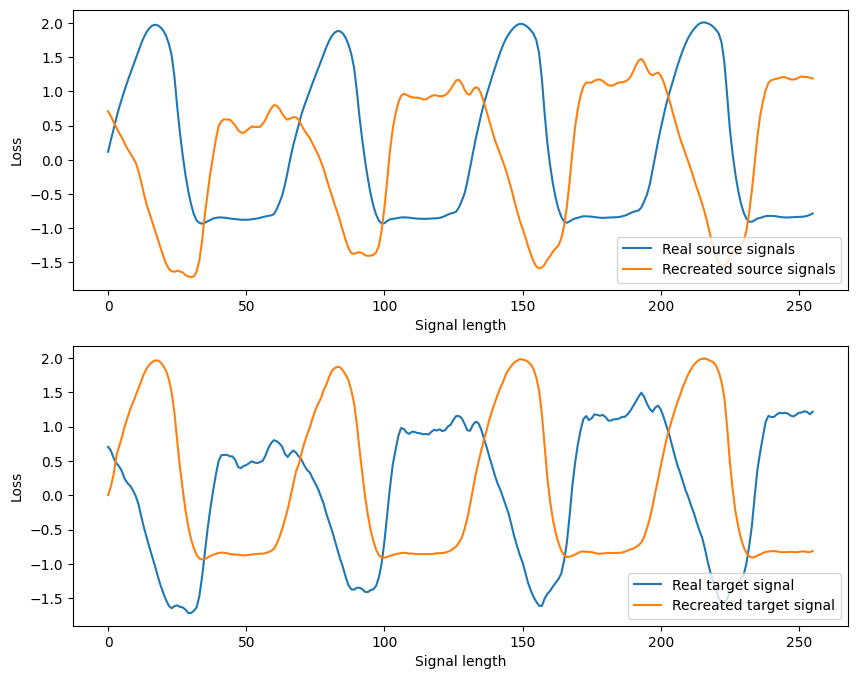

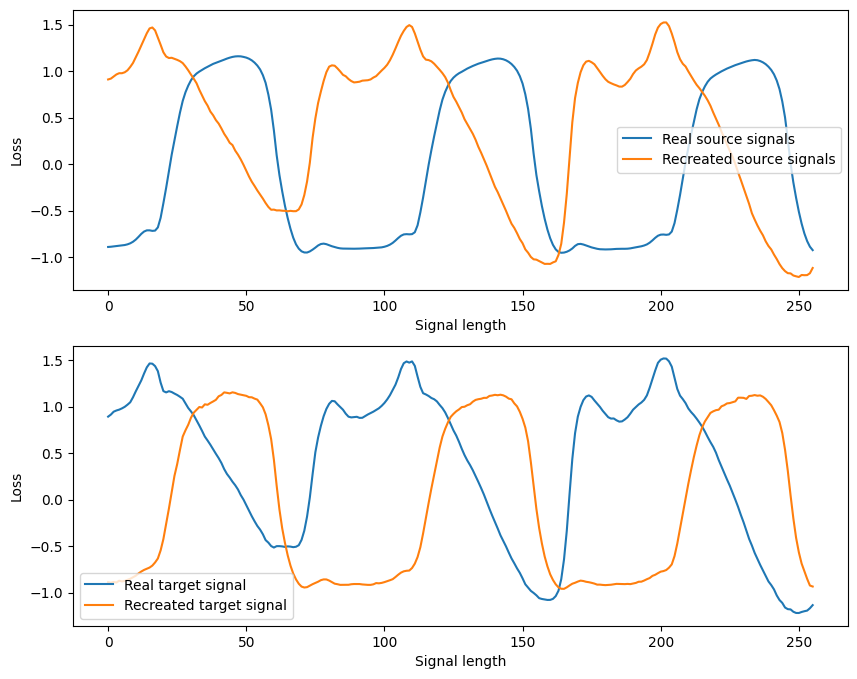

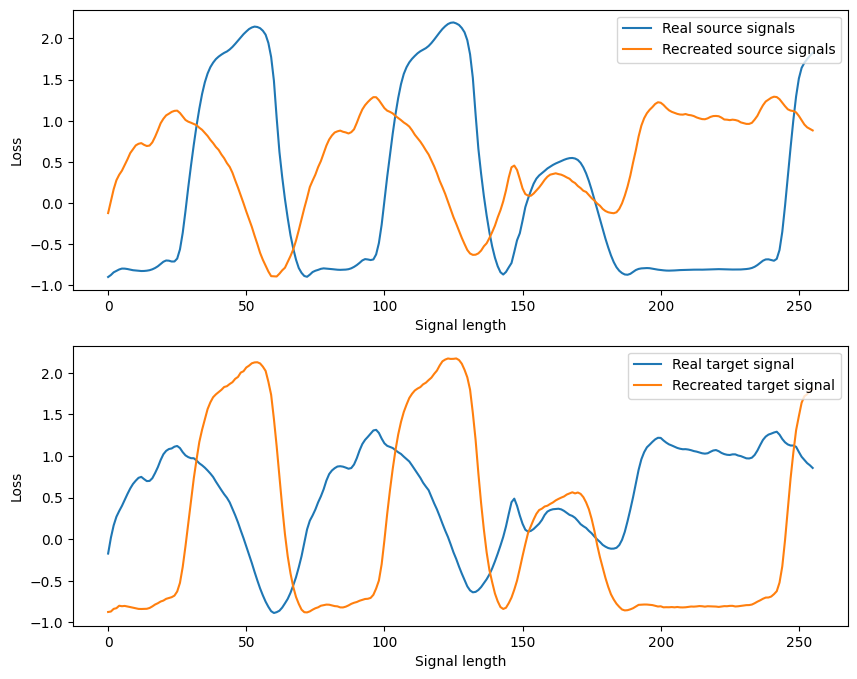

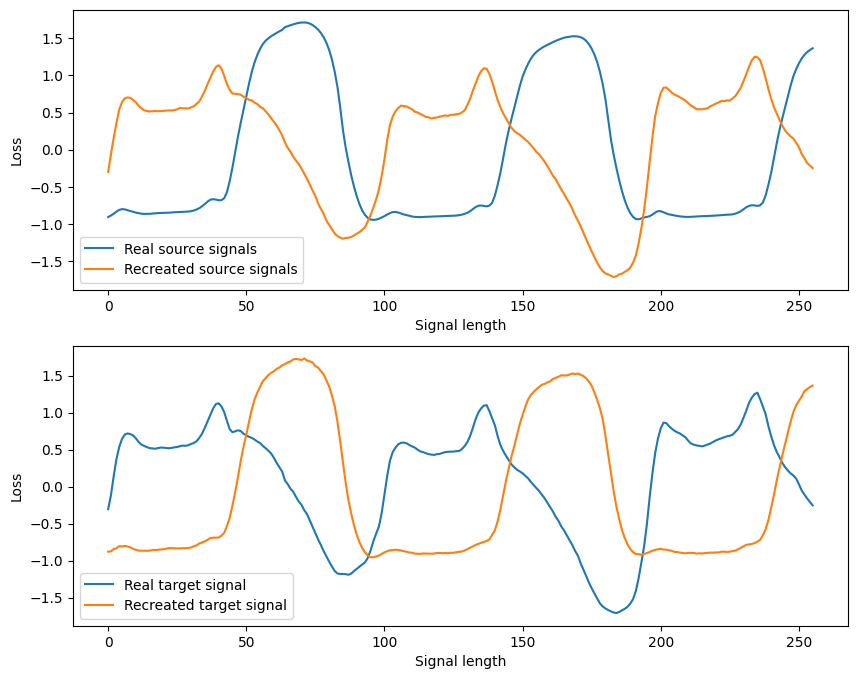

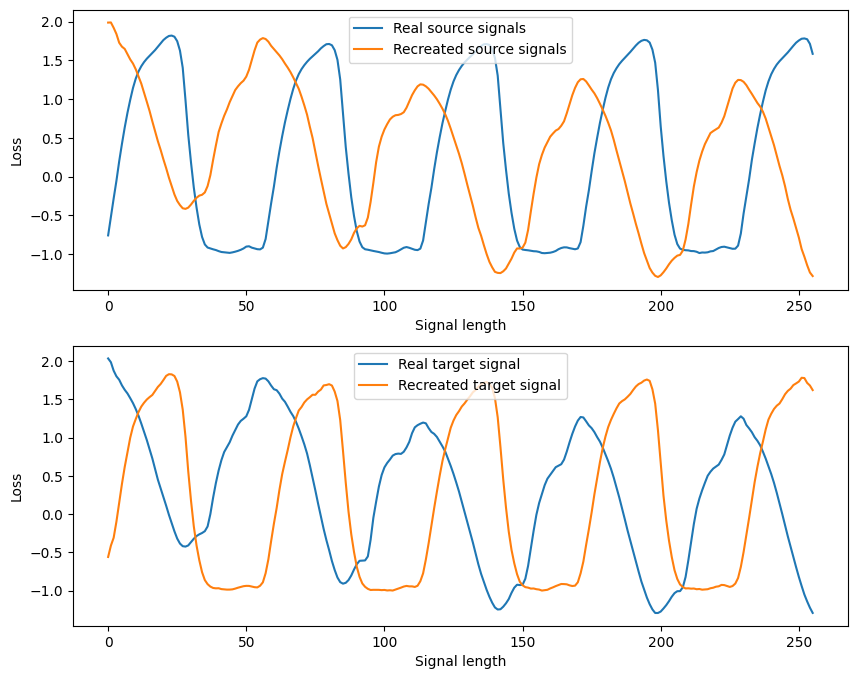

In [52]:
# Generate signals
idx = 0             
phases = df['Phasenzuordnung'].unique()
for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
    if idx == 5:
        break                 
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_source(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_target(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)

                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1       

In [ ]:
# utils.save_checkpoint(gen_source, opt_gen, path="gen_source.pth.tar")
# utils.save_checkpoint(gen_target, opt_gen, path="gen_target.pth.tar")
# utils.save_checkpoint(disc_source, opt_disc, path="disc_source.pth.tar")
# utils.save_checkpoint(disc_target, opt_disc, path="disc_target.pth.tar")


In [ ]:
# utils.load_checkpoint("Checkpoints/gen_source.pth.tar", gen_source, opt_gen, LEARNING_RATE)
# utils.load_checkpoint("Checkpoints/gen_target.pth.tar", gen_target, opt_gen, LEARNING_RATE)